# Data - FashionMNIST

> FashionMNIST DataModule

In [1]:
#| default_exp fashionmnist

In [2]:
#| export
import lightning as L
import torch
import torchvision.transforms.functional as F

from slow_diffusion.data import DiffusionDataModule, noisify, show_images
from slow_diffusion.training import UnetLightning

/Users/jeremiahfisher/miniforge3/envs/slow_diffusion/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# |exports
class FashionMNISTDataModule(DiffusionDataModule):
    """Fasion MNIST datamodule"""

    def __init__(self, bs, n_workers=0):
        super().__init__(
            "fashion_mnist",
            bs,
            n_workers,
            img_size=(32, 32),
        )

    def noisify_fn(self, x_0):
        x_0 = F.convert_image_dtype(x_0, torch.float)
        # zero-center so that the mean does not change after adding noise
        x_0 -= 0.5
        return noisify(x_0)

In [4]:
dm = FashionMNISTDataModule(4)
dm.setup()

In [5]:
def preview(dataloder, n=4):
    (x_t, ts), _ = next(iter(dataloder))
    show_images(x_t[:n], [f"t={t.item():.2f}" for t in ts[:n]])

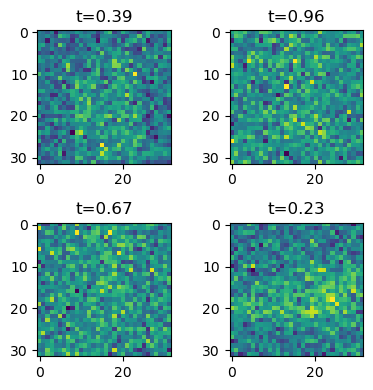

In [6]:
preview(dm.train_dataloader());

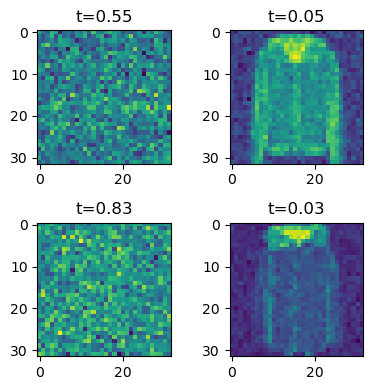

In [7]:
preview(dm.val_dataloader());

In [8]:
unet = UnetLightning(
    nfs=(224, 448, 672, 896),
    n_blocks=(3, 2, 2, 1, 1),
    color_channels=1,
)
trainer = L.Trainer(max_epochs=2, fast_dev_run=True)
trainer.fit(model=unet, datamodule=dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
Loading `train_dataloader` to estimate number of stepping batches.
/Users/jeremiahfisher/miniforge3/envs/slow_diffusion/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | unet    | Unet    | 185 M  | train
1 | loss_fn | MSELoss | 0      | train
--------------------------------------------
185 M     Trainable params
0         Non-trainable params
185 M     Total params
742.125   Total estimated model params size (MB)
/Users/jeremiahfi

Epoch 0: 100%|███████████████████████████████████████| 1/1 [00:02<00:00,  0.40it/s]
Validation: |                                                | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|███████████████████████████████████████| 1/1 [00:02<00:00,  0.37it/s]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 0: 100%|███████████████████████████████████████| 1/1 [00:02<00:00,  0.37it/s]


For debugging, only

In [9]:
# |exports
class TinyFashionMNISTDataModule(FashionMNISTDataModule):
    def post_process(self, ds):
        return ds["train"].select(range(100)).train_test_split(test_size=0.5)

In [10]:
#| hide
import nbdev

nbdev.nbdev_export()